In [1]:
#Carregando as bibliotecas necessárias

from pandas_datareader import data
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AffinityPropagation, Birch
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer, RobustScaler
import seaborn as sns

sns.set()

In [2]:
#Caso exista, faz a leitura do arquivo para um Dataframe, caso contrário, carrega um Dataframe Vazio

prices=pd.DataFrame()

try:
    prices = pd.read_csv('C:\\Pessoal\\Pós IA\\15. TCC\\Prática\\Datasets\\Base_B3.csv', 
                         engine='python', sep=';',index_col=0, parse_dates=True)
except OSError:
    print('Não existe o arquivo')
    prices=pd.DataFrame()

In [3]:
#Lista de Ativos já carregados no Dataframe
tickets_list = np.array(prices.columns.str.slice(0,6).unique().str.replace("_",""))
print(tickets_list)

['ABEV3' 'AMAR3' 'ANIM3' 'AZUL4' 'B3SA3' 'BBAS3' 'BBDC3' 'BBDC4' 'BBSE3'
 'BEEF3' 'BIDI11' 'BPAC11' 'BPAN4' 'BRAP4' 'BRDT3' 'BRFS3' 'BRKM5' 'BRML3'
 'BRSR3' 'BTOW3' 'CAML3' 'CCRO3' 'CIEL3' 'CMIG4' 'COGN3' 'CPFE3' 'CPLE6'
 'CRFB3' 'CSAN3' 'CSNA3' 'CVCB3' 'CYRE3' 'DIRR3' 'ECOR3' 'EGIE3' 'ELET3'
 'ELET6' 'EMBR3' 'ENBR3' 'ENEV3' 'ENGI11' 'EQTL3' 'EZTC3' 'FLRY3' 'GGBR4'
 'GNDI3' 'GOAU4' 'GOLL4' 'HAPV3' 'HBOR3' 'HGTX3' 'HYPE3' 'IGTA3' 'IRBR3'
 'ITSA4' 'ITUB4' 'JBSS3' 'JHSF3' 'KLBN11' 'LAME4' 'LCAM3' 'LIGT3' 'LINX3'
 'LREN3' 'MGLU3' 'MOVI3' 'MRFG3' 'MRVE3' 'MULT3' 'NTCO3' 'ODPV3' 'PCAR3'
 'PETR3' 'PETR4' 'PRIO3' 'PSSA3' 'QUAL3' 'RADL3' 'RAIL3' 'RENT3' 'SANB11'
 'SAPR11' 'SBSP3' 'SEER3' 'SULA11' 'SUZB3' 'TAEE11' 'TOTS3' 'UGPA3'
 'USIM5' 'VALE3' 'VIVT3' 'VVAR3' 'WEGE3' 'YDUQ3']


In [ ]:
#Menor e maior data carregada no Dataframe
prices.index = pd.to_datetime(prices.index, format='%d/%m/%Y')
print('Data Início:', prices.index.min().strftime('%d/%m/%Y'))
print('Data Fim:', prices.index.max().strftime('%d/%m/%Y'))

In [ ]:
#Verificando se existem valores nulos no Dataset
prices.isnull().values.any()

In [ ]:
#Códigos do Ativos que irão ser incluídos no Dataframe
tickers = [ 'TIMS3']

# Rotina para que anexe os dados os dados extraídos do Yahoo Finance para o Dataframe
# Já é feito o tratamento para que tenhamos uma coluna específica para cada dado do ativo

for t in tickers:
    prices[t+'_Abertura']=np.round(data.DataReader(t+'.SA', data_source='yahoo', 
                                                   start='2020-1-1', end='2020-12-31')['Open'], decimals= 2)
    prices[t+'_Fechamento']=np.round(data.DataReader(t+'.SA', data_source='yahoo', start='2020-1-1', 
                                            end='2020-12-31')['Close'], decimals= 2)
    prices[t+'_Movimento']=np.round(prices[t+'_Fechamento']-prices[t+'_Abertura'], decimals= 2)

# Rotina para remover colunas que possuam valores nulos 
# Intuito de remover os ativos que não existem no período analisado
prices = prices.dropna(axis=1)

#Ordena as colunas
column_names = np.array(prices.columns)
column_names.sort()
prices = prices.reindex(columns=column_names)

# Para evitar extrações constantes no Yahoo Finance!, grava-se o DataFrame em um arquivo 
prices.to_csv('C:\\Pessoal\\Pós IA\\15. TCC\\Prática\\Datasets\\Base_B3.csv', sep=';')

In [4]:
#Criação de Dataframe contendo somente a movimentação dos Ativos
prices_mov = prices.T[prices.columns.str.contains("_Movimento")].T
prices_mov.columns = prices_mov.columns.str.replace("_Movimento","")
#Criação de Dataframe contendo somente os valores de fechamento dos Ativos
prices_closed = prices.T[prices.columns.str.contains("_Fechamento")].T
prices_closed.columns = prices_closed.columns.str.replace("_Fechamento","")
#Criação de Dataframe contendo variação de preço diário dos ativos
daily_returns = prices_closed.pct_change().dropna(axis=0)

In [5]:
prices_mov.T.describe()

Date,2020-02-01,2020-03-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-01-13,2020-01-14,2020-01-15,...,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-21,2020-12-22,2020-12-23,2020-12-28,2020-12-29,2020-12-30
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,...,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,0.431263,0.371789,-0.083579,0.011368,-0.146211,0.035263,0.032842,0.406105,0.176947,-0.109895,...,0.482737,0.254526,0.087263,-0.152842,0.225789,0.010947,0.255158,0.217053,-0.051474,-0.090316
std,0.710433,0.687990,0.665542,0.661296,0.564869,0.659695,0.845737,0.656338,0.692794,0.520953,...,0.768157,0.634618,0.781672,0.594698,0.711097,0.730465,0.886373,0.664209,0.444582,0.769958
min,-1.130000,-1.310000,-2.810000,-2.570000,-1.840000,-2.000000,-1.520000,-1.310000,-3.800000,-1.150000,...,-0.480000,-1.330000,-1.730000,-2.930000,-0.990000,-1.580000,-1.610000,-1.440000,-1.780000,-3.650000
25%,0.020000,-0.045000,-0.345000,-0.285000,-0.420000,-0.235000,-0.285000,0.015000,-0.130000,-0.410000,...,0.000000,-0.055000,-0.320000,-0.380000,-0.155000,-0.360000,-0.095000,-0.085000,-0.215000,-0.435000
50%,0.320000,0.270000,-0.110000,0.000000,-0.130000,0.000000,-0.070000,0.280000,0.150000,-0.170000,...,0.300000,0.160000,-0.080000,-0.120000,0.050000,-0.030000,0.160000,0.100000,-0.030000,-0.160000
75%,0.705000,0.715000,0.125000,0.375000,0.135000,0.335000,0.185000,0.735000,0.485000,0.110000,...,0.585000,0.470000,0.300000,0.120000,0.295000,0.275000,0.415000,0.305000,0.160000,0.170000
max,2.500000,2.960000,2.420000,1.940000,1.850000,3.210000,5.900000,2.470000,2.500000,2.110000,...,4.280000,2.730000,3.300000,2.030000,3.560000,2.820000,6.380000,2.640000,1.770000,2.770000


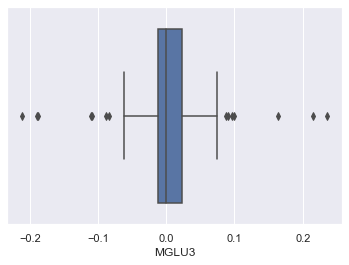

In [6]:
sns.boxplot(x=daily_returns['MGLU3'])
plt.show()

In [7]:
#Exemplificação dos casos de Outliers
daily_returns['MGLU3'].describe()

count    246.000000
mean       0.003861
std        0.044494
min       -0.210771
25%       -0.012544
50%        0.000000
75%        0.023540
max        0.235294
Name: MGLU3, dtype: float64

In [8]:
#Data da Ocorrência dos Outliers
mglu3_min = ''.join(map(str, daily_returns[daily_returns['MGLU3'] == daily_returns['MGLU3'].min()].index.strftime('%d/%m/%Y').values))
mglu3_max = ''.join(map(str, daily_returns[daily_returns['MGLU3'] == daily_returns['MGLU3'].max()].index.strftime('%d/%m/%Y').values))
print('Data da Mínima de 2020:', mglu3_min)
print('Data da Máxima de 2020:', mglu3_max)

Data da Mínima de 2020: 03/12/2020
Data da Máxima de 2020: 13/03/2020


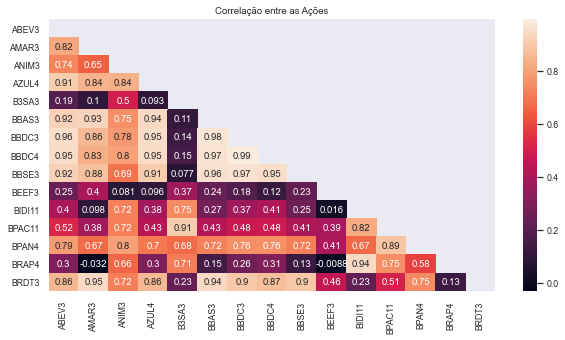

In [9]:
#Correlação dos Movimentos
matrix = np.triu(prices_closed.T[0:15].T.corr())
sns.set(font_scale=0.8)
plt.figure(figsize=(10, 5))
plt.title('Correlação entre as Ações')
sns.heatmap(prices_closed.T[0:15].T.corr(), annot=True, mask=matrix, fmt='.2g')
plt.show()

In [10]:
#Normalização do Movimentação dos preços dos ativos
normalizer = Normalizer()
prices_mov_nm = pd.DataFrame(normalizer.fit_transform(prices_mov.T), index=prices_mov.columns, columns=prices_mov.index)
prices_cls_nm = pd.DataFrame(normalizer.fit_transform(prices_closed.T), index=prices_closed.columns, columns=prices_closed.index)

In [11]:
#Comparação de ativos do mesmo setor com Alta Correlação
A = ['BBDC4', 'BBAS3']

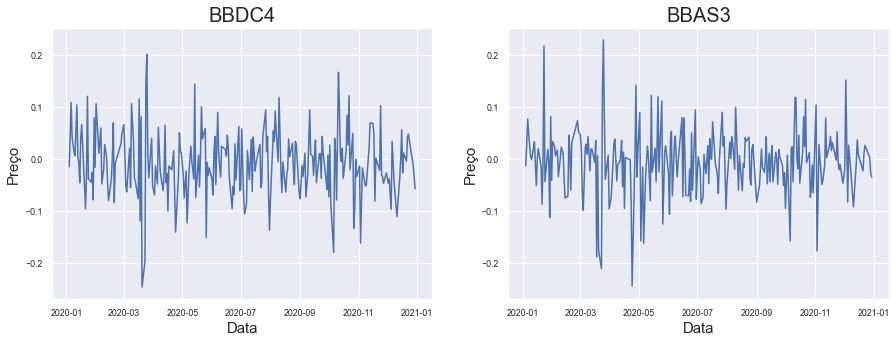

In [12]:
#Nesta visualização, vemos que o comportamento temporal dos movimentos, já com os dados normalizados
plt.figure(1, figsize = (15,5)) 
ax1 = plt.subplot(1,2,1) 
plt.title(A[0],fontsize = 20)
plt.xlabel('Data',fontsize = 15)
plt.ylabel('Preço',fontsize = 15)
sns.lineplot(data=prices_mov_nm.T, x=prices_mov_nm.T.index, y=A[0])
plt.subplot(1,2,2, sharey = ax1) 
plt.title(A[1],fontsize = 20)
plt.xlabel('Data',fontsize = 15)
plt.ylabel('Preço',fontsize = 15)
sns.lineplot(data=prices_mov_nm.T, x=prices_mov_nm.T.index, y=A[1])
plt.show()

In [13]:
#Comparação de ativos com Baixa Correlação
B = ['BBAS3', 'AZUL4']

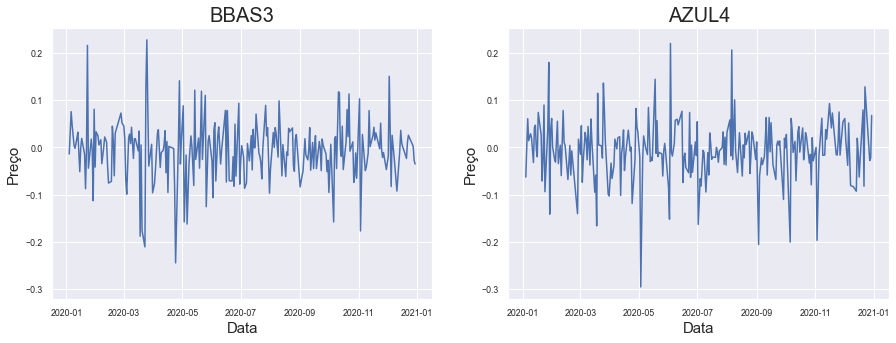

In [14]:
#Nesta visualização, vemos uma correlação alta entre dois ativos de segmentos diferentes
#Com isso vemos movimentos muito parecidos
plt.figure(1, figsize = (15,5)) 
ax1 = plt.subplot(1,2,1) 
plt.title(B[0],fontsize = 20)
plt.xlabel('Data',fontsize = 15)
plt.ylabel('Preço',fontsize = 15)
sns.lineplot(data=prices_mov_nm.T, x=prices_mov_nm.T.index, y=B[0])
plt.subplot(1,2,2, sharey = ax1) 
plt.title(B[1],fontsize = 20)
plt.xlabel('Data',fontsize = 15)
plt.ylabel('Preço',fontsize = 15)
sns.lineplot(data=prices_mov_nm.T, x=prices_mov_nm.T.index, y=B[1])
plt.show()

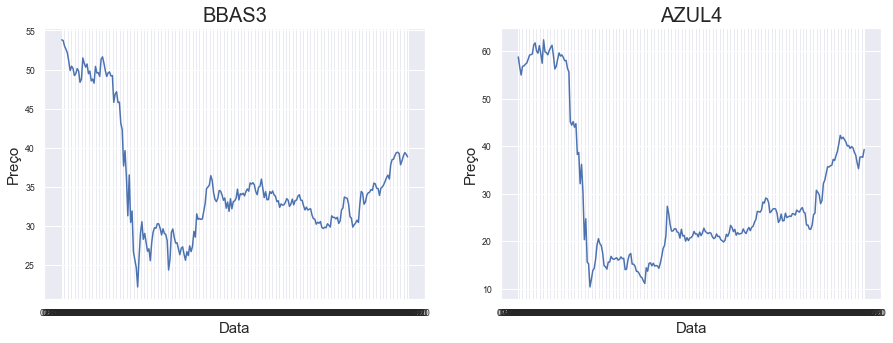

In [15]:
plt.figure(1, figsize = (15,5)) 
ax1 = plt.subplot(1,2,1) 
plt.title(B[0],fontsize = 20)
plt.xlabel('Data',fontsize = 15)
plt.ylabel('Preço',fontsize = 15)
sns.lineplot(data=prices_closed, x=prices_closed.index.strftime('%m/%d/%Y'), y=B[0])
plt.subplot(1,2,2) 
plt.title(B[1],fontsize = 20)
plt.xlabel('Data',fontsize = 15)
plt.ylabel('Preço',fontsize = 15)
sns.lineplot(data=prices_closed, x=prices_closed.index.strftime('%m/%d/%Y'), y=B[1])
plt.show()

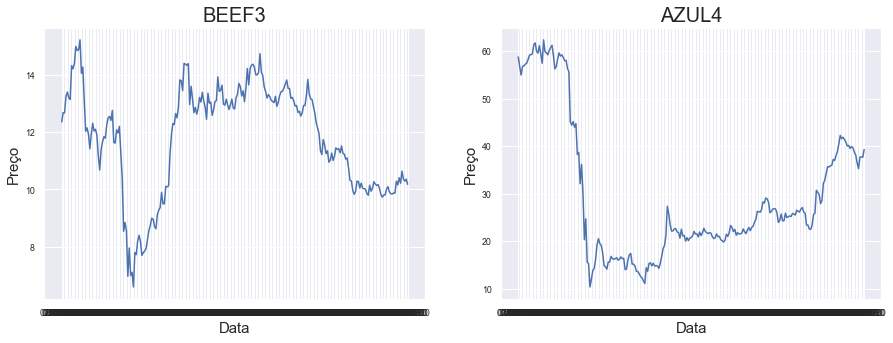

In [16]:
plt.figure(1, figsize = (15,5)) 
ax1 = plt.subplot(1,2,1) 
plt.title('BEEF3',fontsize = 20)
plt.xlabel('Data',fontsize = 15)
plt.ylabel('Preço',fontsize = 15)
sns.lineplot(data=prices_closed, x=prices_closed.index.strftime('%m/%d/%Y'), y='BEEF3')
plt.subplot(1,2,2) 
plt.title('AZUL4',fontsize = 20)
plt.xlabel('Data',fontsize = 15)
plt.ylabel('Preço',fontsize = 15)
sns.lineplot(data=prices_closed, x=prices_closed.index.strftime('%m/%d/%Y'), y='AZUL4')
plt.show()

In [17]:
#Criando DataFrame com a rentabilidade acumulada diariamente
acc_daily_returns = (1+daily_returns).cumprod()-1
year_returns = acc_daily_returns[-1:].T
year_returns = pd.DataFrame(np.array(acc_daily_returns[-1:].T), index = tickets_list, columns=["Rentab_2020"])

In [18]:
plt.title("Distribuição da Rentabilidade em 2020")
plt.xlabel('% Valorização')
plt.ylabel('Qtde de Ativos')
sns.histplot(data=year_returns*100, bins=10, kde=True)

<AxesSubplot:title={'center':'Distribuição da Rentabilidade em 2020'}, xlabel='% Valorização', ylabel='Qtde de Ativos'>

In [19]:
#Incluindo o desvio padrão para termos a volatilidade diária
year_returns["Volatility"] = daily_returns.std()

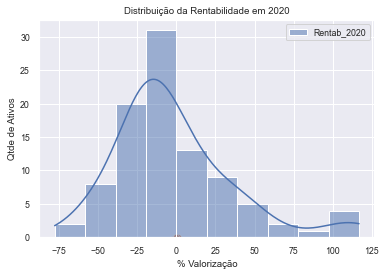

In [20]:
sns.scatterplot(data=year_returns, x="Rentab_2020", y="Volatility")
plt.show()

In [21]:
year_returns["Volatility"] = daily_returns.std()
year_returns

,Rentab_2020,Volatility
ABEV3,-0.184896,0.029531
AMAR3,-0.494056,0.061822
ANIM3,0.216216,0.043352
AZUL4,-0.331633,0.071177
B3SA3,0.373975,0.036048
...,...,...
VALE3,0.609608,0.035294
VIVT3,-0.036070,0.027104
VVAR3,0.377664,0.058276
WEGE3,1.149262,0.036899


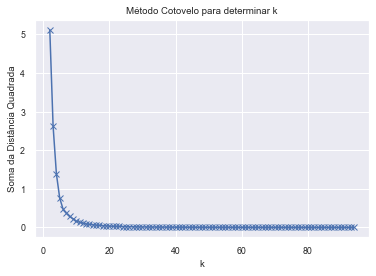

In [22]:
Sum_of_squared_distances = []

for i in range(2,len(tickets_list)):
    kmeans = KMeans(init='k-means++', n_clusters=i, max_iter=100)
    kmeans.fit_transform(year_returns)
    yhat = kmeans.predict(year_returns)
    Sum_of_squared_distances.append(kmeans.inertia_)
    
plt.plot(range(2,len(tickets_list)), Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma da Distância Quadrada')
plt.title('Método Cotovelo para determinar k')
plt.show()

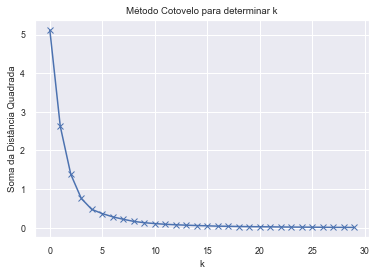

In [23]:
plt.plot(range(0,30), Sum_of_squared_distances[0:30], 'bx-')
plt.xlabel('k')
plt.ylabel('Soma da Distância Quadrada')
plt.title('Método Cotovelo para determinar k')
plt.show()

In [24]:
kmeans = KMeans(init='k-means++', n_clusters=4, max_iter=1000)
kmeans.fit_transform(year_returns)
yhat = kmeans.predict(year_returns)

In [25]:
yhat_pd = pd.DataFrame(yhat.T, index=tickets_list, columns=["Label"])
year_returns_labeled = pd.concat([year_returns, yhat_pd], axis=1)
year_returns_labeled["Rentab_2020"] = year_returns_labeled["Rentab_2020"]*100

In [26]:
df_rentab_groupby_cluster = year_returns_labeled.groupby(['Label'], 
                                  as_index=False).mean()
df_rentab_groupby_cluster["Rentab_2020"] = df_rentab_groupby_cluster["Rentab_2020"]*100

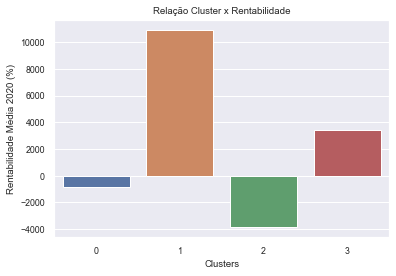

In [28]:
plt.title('Relação Cluster x Rentabilidade')
fig = sns.barplot(data=df_rentab_groupby_cluster, y="Rentab_2020", x="Label")
fig.set(xlabel='Clusters', ylabel='Rentabilidade Média 2020 (%)')
plt.show()

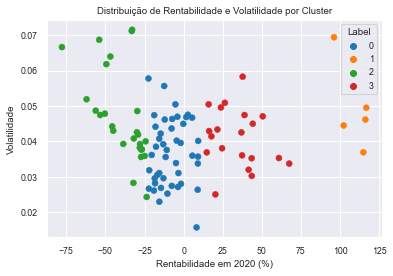

In [29]:
plt.title('Distribuição de Rentabilidade e Volatilidade por Cluster')
fig = sns.scatterplot(x="Rentab_2020", y="Volatility", edgecolor='face', hue="Label",
                     data=year_returns_labeled, palette="tab10")
fig.set(xlabel='Rentabilidade em 2020 (%)', ylabel='Volatilidade')
plt.show()

In [30]:
prices_cls_nm

Date,2020-02-01,2020-03-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-01-13,2020-01-14,2020-01-15,...,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-21,2020-12-22,2020-12-23,2020-12-28,2020-12-29,2020-12-30
ABEV3,0.085939,0.084730,0.085133,0.085312,0.084909,0.084238,0.084551,0.085984,0.085491,0.083969,...,0.069646,0.070810,0.071884,0.071571,0.069020,0.069422,0.069378,0.070586,0.071392,0.070049
AMAR3,0.097170,0.100707,0.098397,0.098686,0.100130,0.103306,0.103162,0.103739,0.102440,0.100058,...,0.052267,0.052195,0.051112,0.051473,0.049957,0.047646,0.047791,0.047069,0.049235,0.049162
ANIM3,0.065002,0.065771,0.066320,0.071239,0.071964,0.071217,0.069680,0.070580,0.070273,0.072030,...,0.082241,0.083559,0.084547,0.082263,0.081846,0.079694,0.079716,0.079123,0.079342,0.079057
AZUL4,0.114036,0.110080,0.106666,0.110196,0.110390,0.111088,0.111515,0.113066,0.114792,0.115006,...,0.077401,0.076955,0.075132,0.073949,0.070788,0.068402,0.073115,0.073251,0.073057,0.076218
B3SA3,0.055139,0.053550,0.053036,0.054748,0.054601,0.054576,0.054149,0.054210,0.054576,0.053110,...,0.071970,0.074011,0.073889,0.073693,0.072117,0.073681,0.073327,0.075172,0.075564,0.075759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALE3,0.059211,0.058775,0.058426,0.058851,0.058862,0.058088,0.058154,0.060268,0.060638,0.060442,...,0.092091,0.093965,0.095033,0.096112,0.094663,0.094750,0.095208,0.095153,0.094892,0.095306
VIVT3,0.063183,0.063917,0.063301,0.064703,0.065358,0.064257,0.065855,0.067846,0.069339,0.069405,...,0.059909,0.060145,0.060498,0.059883,0.059044,0.059451,0.059581,0.060119,0.059202,0.060904
VVAR3,0.048165,0.047139,0.047139,0.047837,0.047631,0.047878,0.048042,0.052148,0.054817,0.055638,...,0.069887,0.070215,0.069681,0.069599,0.066314,0.065452,0.066232,0.068121,0.068080,0.066355
WEGE3,0.038963,0.038465,0.038565,0.038863,0.037393,0.036840,0.037592,0.037946,0.038698,0.038952,...,0.080436,0.081044,0.083775,0.080568,0.079618,0.080513,0.080292,0.083476,0.083089,0.083742


In [31]:
# Remove o cluster 3 que foi considerada a pior rentabilidade de 2020
prices_cls_nm_rent = pd.concat([prices_cls_nm, year_returns_labeled["Label"]], axis=1)
prices_cls_nm_filt = prices_cls_nm_rent[(prices_cls_nm_rent.Label != 3)]
prices_cls_nm_filt = prices_cls_nm_filt.drop("Label", axis=1)

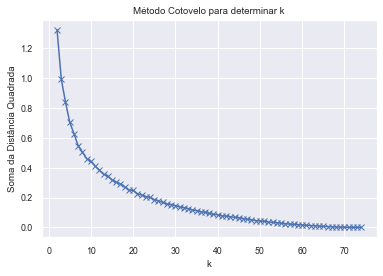

In [32]:
Sum_of_squared_distances = []

for i in range(2,len(prices_cls_nm_filt.index)):
    kmeans = KMeans(init='k-means++', n_clusters=i, max_iter=1000)
    kmeans.fit_transform(prices_cls_nm_filt)
    yhat = kmeans.predict(prices_cls_nm_filt)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(range(2,len(prices_cls_nm_filt.index)), Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Soma da Distância Quadrada')
plt.title('Método Cotovelo para determinar k')
plt.show()

In [33]:
names = ['Davies Bouldin', 'Silhouette', 'Calinski Harabasz', 'Variância Média']
kpi = pd.DataFrame(index=names)

In [34]:
def Variancia_Media (data, yhat):
    yhat_pd = pd.DataFrame(yhat.T, index=data.index, columns=["Label"])
    std_price = pd.DataFrame(data.T.std(), index=data.index, columns=["Desvio Padrão"])
    x = pd.concat([std_price, yhat_pd], axis=1)
    x_groupby_cluster = x.groupby(['Label'], 
                                  as_index=False).mean()
    return x_groupby_cluster["Desvio Padrão"].mean()

In [35]:
kmeans = KMeans(init='k-means++', n_clusters=15, max_iter=1000)
kmeans.fit_transform(prices_cls_nm_filt)
yhat = kmeans.predict(prices_cls_nm_filt)
kpi_list = []
kpi_list.append(davies_bouldin_score(prices_cls_nm_filt, yhat))
kpi_list.append(silhouette_score(prices_cls_nm_filt, yhat))
kpi_list.append(calinski_harabasz_score(prices_cls_nm_filt, yhat))
kpi_list.append(Variancia_Media(prices_cls_nm_filt, yhat))
print('Davies Bouldin:', kpi_list[0])
print('Silhouette:', kpi_list[1])
print('Calinski Harabasz Score:', kpi_list[2])
print('Variância Média:', kpi_list[3])

Davies Bouldin: 1.0514323328181885
Silhouette: 0.18628215421788077
Calinski Harabasz Score: 22.1234483518674
Variância Média: 0.017114057106718827


In [36]:
kpi["K-means"] = pd.DataFrame(kpi_list, index=names)

In [37]:
affinitypropagation = AffinityPropagation(damping=0.5)
affinitypropagation.fit(prices_cls_nm_filt)
yhat = affinitypropagation.predict(prices_cls_nm_filt)
kpi_list = []
kpi_list.append(davies_bouldin_score(prices_cls_nm_filt, yhat))
kpi_list.append(silhouette_score(prices_cls_nm_filt, yhat))
kpi_list.append(calinski_harabasz_score(prices_cls_nm_filt, yhat))
kpi_list.append(Variancia_Media(prices_cls_nm_filt, yhat))
print('Davies Bouldin:', kpi_list[0])
print('Silhouette:', kpi_list[1])
print('Calinski Harabasz Score:', kpi_list[2])
print('Variância Média:', kpi_list[3])


Davies Bouldin: 1.0228264069921784
Silhouette: 0.18506313803927288
Calinski Harabasz Score: 23.271184723359656
Variância Média: 0.018181678301766157


C:\Users\929001115\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning


In [38]:
kpi["Affinity Propagation"] = pd.DataFrame(kpi_list, index=names)

In [39]:
birch = Birch(threshold=0.01, n_clusters=15)
birch.fit(prices_cls_nm_filt)
yhat = birch.predict(prices_cls_nm_filt)
kpi_list = []
kpi_list.append(davies_bouldin_score(prices_cls_nm_filt, yhat))
kpi_list.append(silhouette_score(prices_cls_nm_filt, yhat))
kpi_list.append(calinski_harabasz_score(prices_cls_nm_filt, yhat))
kpi_list.append(Variancia_Media(prices_cls_nm_filt, yhat))
print('Davies Bouldin:', kpi_list[0])
print('Silhouette:', kpi_list[1])
print('Calinski Harabasz Score:', kpi_list[2])
print('Variância Média:', kpi_list[3])

Davies Bouldin: 0.9474155010950656
Silhouette: 0.19584572655698892
Calinski Harabasz Score: 22.558241089048078
Variância Média: 0.01777405738098834


In [40]:
kpi["Birch"] = pd.DataFrame(kpi_list, index=names)

In [149]:
# Visualização dos resultados em PCA-reduced data
reduced_data = PCA(n_components=2).fit_transform(prices_cls_nm_filt)
kmeans = KMeans(init='k-means++', n_clusters=15, n_init=100)
kmeans.fit(reduced_data)
labels = kmeans.predict(reduced_data)

df = pd.DataFrame({'labels': labels, 'companies': prices_cls_nm_filt.index})

In [150]:
data = pd.concat([pd.DataFrame(reduced_data, columns=["X","Y"]), df], axis=1)

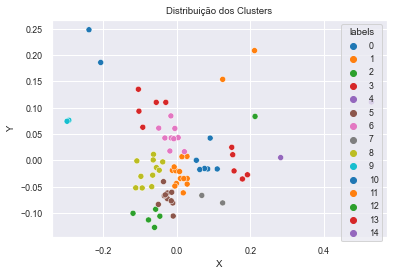

In [151]:
plt.title("Distribuição dos Clusters")
sns.scatterplot(data=data, x="X", y="Y", palette="tab10", hue="labels")
plt.show()

In [153]:
data[labels==1]

,X,Y,labels,companies
0,-0.012328,-0.018948,1,ABEV3
4,0.027642,0.007603,1,BBDC3
5,0.013860,0.007067,1,BBDC4
6,-0.001154,-0.043838,1,BBSE3
10,0.009778,-0.034315,1,BRDT3
12,0.028242,-0.034484,1,BRKM5
15,0.017478,-0.061751,1,CCRO3
27,0.018962,-0.034582,1,ECOR3
44,-0.002846,-0.019670,1,ITSA4
45,-0.007288,-0.012406,1,ITUB4


In [154]:
clusters_rentab = year_returns_labeled.join(data.set_index("companies")).dropna(axis=0)

In [155]:
groupby_clusters_rentab = clusters_rentab.groupby(['labels'], 
                                  as_index=False).mean()

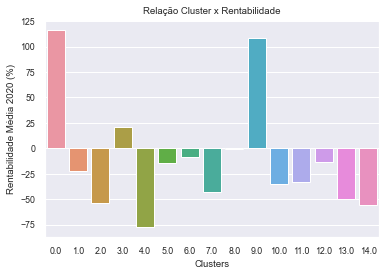

In [156]:
plt.title('Relação Cluster x Rentabilidade')
fig = sns.barplot(data=groupby_clusters_rentab, y="Rentab_2020", x="labels")
fig.set(xlabel='Clusters', ylabel='Rentabilidade Média 2020 (%)')
plt.show()

In [143]:
groupby_clusters_rentab["Rentab_2020"].mean()

0.7505247147696917

In [144]:
groupby_clusters_rentab = clusters_rentab.groupby(['labels'], 
                                  as_index=False).max()

In [145]:
groupby_clusters_rentab["Rentab_2020"].mean()

13.218672404246455

In [146]:
groupby_clusters_rentab = clusters_rentab.groupby(['labels'], 
                                  as_index=False).min()

In [147]:
groupby_clusters_rentab["Rentab_2020"].mean()

-8.385734383018757